# ML Model - Linear Regression

#### In this notebook we will be building a linear regression model with multiple input features to predict a movie's box office (inflation-adjusted).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

In [2]:
# Visualize more columns
pd.options.display.max_columns = None

In [3]:
path = os.path.join('..', '..', 'resources','cleaned_data', 'movies_complete_cleaned.csv')
df = pd.read_csv(path)
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

df.head()

,name,production,director,runtime,released,year,month,country_kaggle,country_omdb,star_kaggle,actors_omdb,writer_kaggle,writers_omdb,language_omdb,plot,awards,score_imdb,votes_imdb,score_metacritic,budget,genre_kaggle,gross,genres_omdb,rating
0,Doctor Strange,Marvel Studios,Scott Derrickson,115,2016-11-04,2016,11,USA,USA,Benedict Cumberbatch,"Benedict Cumberbatch, Chiwetel Ejiofor, Rachel...",Jon Spaihts,"Jon Spaihts, Scott Derrickson, C. Robert Cargi...",English,"Marvel's ""Doctor Strange"" follows the story of...",Nominated for 1 Oscar. Another 19 wins & 67 no...,7.5,348307,72.0,165000000,Action,232641920,"Action, Adventure, Fantasy, Sci-Fi",PG-13
1,Sleight,Diablo Entertainment (II),J.D. Dillard,89,2017-04-28,2016,4,USA,USA,Jacob Latimore,"Jacob Latimore, Seychelle Gabriel, Storm Reid,...",J.D. Dillard,"J.D. Dillard, Alex Theurer",English,A young street magician (Jacob Latimore) is le...,3 nominations.,5.9,4012,62.0,250000,Action,3986245,"Crime, Drama, Sci-Fi",R
2,Silence,Cappa Defina Productions,Martin Scorsese,161,2017-01-13,2016,1,USA,"USA, UK, Taiwan, Japan, Mexico, Italy",Andrew Garfield,"Andrew Garfield, Adam Driver, Liam Neeson, Tad...",Jay Cocks,"Jay Cocks (screenplay by), Martin Scorsese (sc...","English, Japanese, Latin",The story of two Catholic missionaries (Andrew...,Nominated for 1 Oscar. Another 6 wins & 56 nom...,7.2,61798,79.0,46000000,Adventure,7100177,"Drama, History",R
3,Manchester by the Sea,Amazon Studios,Kenneth Lonergan,137,2016-12-16,2016,12,USA,USA,Casey Affleck,"Casey Affleck, Ben O'Brien, Kyle Chandler, Ric...",Kenneth Lonergan,Kenneth Lonergan,English,"Lee Chandler is a brooding, irritable loner wh...",Won 2 Oscars. Another 127 wins & 263 nominations.,7.9,159673,96.0,8500000,Drama,47695371,Drama,R
4,Dirty Grandpa,Lionsgate,Dan Mazer,102,2016-01-22,2016,1,USA,"United States, United Kingdom",Robert De Niro,"Robert De Niro, Zac Efron, Zoey Deutch",John Phillips,John Phillips,English,"Jason Kelly, the grandson of Dick Kelly, loses...",2 wins & 11 nominations,6.0,82289,21.0,27500000,Comedy,35593113,Comedy,R


In [4]:
# Check the number of null rows
df.isna().sum()

name                   0
production             0
director               0
runtime                0
released               0
year                   0
month                  0
country_kaggle         0
country_omdb         305
star_kaggle            0
actors_omdb          322
writer_kaggle          0
writers_omdb         340
language_omdb        315
plot                 342
awards              1325
score_imdb             0
votes_imdb             0
score_metacritic    1572
budget                 0
genre_kaggle           0
gross                  0
genres_omdb          307
rating                 0
dtype: int64

*The above null values will be part of the factors to help us determine which features to select.*

## Data Gathering

We know that the gross and budget values were not adjusted for inflation, thus we will replace these columns with adjusted values from `adjusted_financials.csv`

**Adjusted Financials Merge**

In [5]:
# Merge adjustd financials (budget and gross) into the original df
path_adj = os.path.join('..', '..', 'resources','cleaned_data', 'adjusted_financials.csv')
df_adj = pd.read_csv(path_adj)

df_adj.head()

,name,year,budget,gross,adjusted_budget,adjusted_gross
0,Doctor Strange,2016,165000000,232641920,177927373,250868883
1,Sleight,2016,250000,3986245,269587,4298558
2,Silence,2016,46000000,7100177,49603995,7656460
3,Manchester by the Sea,2016,8500000,47695371,9165956,51432194
4,Dirty Grandpa,2016,27500000,35593113,29654562,38381752


In [6]:
df_adj = df_adj[['name', 'adjusted_budget', 'adjusted_gross']]

In [7]:
# Merge
merged_df_adj = pd.merge(df, df_adj, on="name", how="inner")
merged_df_adj.head(2)

,name,production,director,runtime,released,year,month,country_kaggle,country_omdb,star_kaggle,actors_omdb,writer_kaggle,writers_omdb,language_omdb,plot,awards,score_imdb,votes_imdb,score_metacritic,budget,genre_kaggle,gross,genres_omdb,rating,adjusted_budget,adjusted_gross
0,Doctor Strange,Marvel Studios,Scott Derrickson,115,2016-11-04,2016,11,USA,USA,Benedict Cumberbatch,"Benedict Cumberbatch, Chiwetel Ejiofor, Rachel...",Jon Spaihts,"Jon Spaihts, Scott Derrickson, C. Robert Cargi...",English,"Marvel's ""Doctor Strange"" follows the story of...",Nominated for 1 Oscar. Another 19 wins & 67 no...,7.5,348307,72.0,165000000,Action,232641920,"Action, Adventure, Fantasy, Sci-Fi",PG-13,177927373,250868883
1,Sleight,Diablo Entertainment (II),J.D. Dillard,89,2017-04-28,2016,4,USA,USA,Jacob Latimore,"Jacob Latimore, Seychelle Gabriel, Storm Reid,...",J.D. Dillard,"J.D. Dillard, Alex Theurer",English,A young street magician (Jacob Latimore) is le...,3 nominations.,5.9,4012,62.0,250000,Action,3986245,"Crime, Drama, Sci-Fi",R,269587,4298558


**Months (Seasons) Merge**

In order to make the months more meaningful, we grouped them into seasons and will only use seasons as feature inputs.

In [8]:
# Merge parsed/encoded months into the original df
path_months = os.path.join('..', '..', 'resources','cleaned_data', 'parsed_months_table.csv')
df_months = pd.read_csv(path_months)

df_months.head()

,name,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,spring,summer,fall,winter
0,Doctor Strange,11,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,Sleight,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,Silence,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Manchester by the Sea,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,Dirty Grandpa,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
# Merge
df_months.rename(columns={'month': 'month_delete'}, inplace=True)
merged_df_months = pd.merge(merged_df_adj, df_months, on="name", how="inner")
merged_df_months.head(2)

,name,production,director,runtime,released,year,month,country_kaggle,country_omdb,star_kaggle,actors_omdb,writer_kaggle,writers_omdb,language_omdb,plot,awards,score_imdb,votes_imdb,score_metacritic,budget,genre_kaggle,gross,genres_omdb,rating,adjusted_budget,adjusted_gross,month_delete,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,spring,summer,fall,winter
0,Doctor Strange,Marvel Studios,Scott Derrickson,115,2016-11-04,2016,11,USA,USA,Benedict Cumberbatch,"Benedict Cumberbatch, Chiwetel Ejiofor, Rachel...",Jon Spaihts,"Jon Spaihts, Scott Derrickson, C. Robert Cargi...",English,"Marvel's ""Doctor Strange"" follows the story of...",Nominated for 1 Oscar. Another 19 wins & 67 no...,7.5,348307,72.0,165000000,Action,232641920,"Action, Adventure, Fantasy, Sci-Fi",PG-13,177927373,250868883,11,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,Sleight,Diablo Entertainment (II),J.D. Dillard,89,2017-04-28,2016,4,USA,USA,Jacob Latimore,"Jacob Latimore, Seychelle Gabriel, Storm Reid,...",J.D. Dillard,"J.D. Dillard, Alex Theurer",English,A young street magician (Jacob Latimore) is le...,3 nominations.,5.9,4012,62.0,250000,Action,3986245,"Crime, Drama, Sci-Fi",R,269587,4298558,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [10]:
# Remove all month columns but also keep the seasons
merged_df_seasons = merged_df_months.drop(columns=['month_delete'])
merged_df_seasons = merged_df_seasons.drop(columns=[
    'Jan', 'Feb', 'Mar', 'Apr',
    'May', 'Jun', 'Jul', 'Aug',
    'Sep', 'Oct', 'Nov', 'Dec'
])
merged_df_seasons.head(2)

,name,production,director,runtime,released,year,month,country_kaggle,country_omdb,star_kaggle,actors_omdb,writer_kaggle,writers_omdb,language_omdb,plot,awards,score_imdb,votes_imdb,score_metacritic,budget,genre_kaggle,gross,genres_omdb,rating,adjusted_budget,adjusted_gross,spring,summer,fall,winter
0,Doctor Strange,Marvel Studios,Scott Derrickson,115,2016-11-04,2016,11,USA,USA,Benedict Cumberbatch,"Benedict Cumberbatch, Chiwetel Ejiofor, Rachel...",Jon Spaihts,"Jon Spaihts, Scott Derrickson, C. Robert Cargi...",English,"Marvel's ""Doctor Strange"" follows the story of...",Nominated for 1 Oscar. Another 19 wins & 67 no...,7.5,348307,72.0,165000000,Action,232641920,"Action, Adventure, Fantasy, Sci-Fi",PG-13,177927373,250868883,0,0,0,1
1,Sleight,Diablo Entertainment (II),J.D. Dillard,89,2017-04-28,2016,4,USA,USA,Jacob Latimore,"Jacob Latimore, Seychelle Gabriel, Storm Reid,...",J.D. Dillard,"J.D. Dillard, Alex Theurer",English,A young street magician (Jacob Latimore) is le...,3 nominations.,5.9,4012,62.0,250000,Action,3986245,"Crime, Drama, Sci-Fi",R,269587,4298558,1,0,0,0


**Genres Merge**

In [11]:
# Merge parsed/encoded genres into the original df
path_genres = os.path.join('..', '..', 'resources','cleaned_data', 'parsed_genres_table.csv')
df_genres = pd.read_csv(path_genres)

df_genres.head()

,name,genre_kaggle,genres_omdb,action,adventure,fantasy,sci-fi,crime,drama,history,comedy,biography,romance,horror,thriller,war,animation,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
0,Doctor Strange,Action,"Action, Adventure, Fantasy, Sci-Fi",1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sleight,Action,"Crime, Drama, Sci-Fi",0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Silence,Adventure,"Drama, History",0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Manchester by the Sea,Drama,Drama,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Grandpa,Comedy,Comedy,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
genres_list = list(df_genres.columns)
unwanted = ['genre_kaggle', 'genres_omdb']
wanted = []
for genre in genres_list:
    if genre not in unwanted:
        wanted.append(genre)
df_genres = df_genres[wanted]
df_genres.columns

Index(['name', 'action', 'adventure', 'fantasy', 'sci-fi', 'crime', 'drama',
       'history', 'comedy', 'biography', 'romance', 'horror', 'thriller',
       'war', 'animation', 'family', 'sport', 'music', 'mystery', 'short',
       'western', 'musical', 'documentary', 'film-noir', 'adult'],
      dtype='object')

In [13]:
# Merge
merged_df_genres = pd.merge(merged_df_seasons, df_genres, on="name", how="inner")
merged_df_genres.head(2)

,name,production,director,runtime,released,year,month,country_kaggle,country_omdb,star_kaggle,actors_omdb,writer_kaggle,writers_omdb,language_omdb,plot,awards,score_imdb,votes_imdb,score_metacritic,budget,genre_kaggle,gross,genres_omdb,rating,adjusted_budget,adjusted_gross,spring,summer,fall,winter,action,adventure,fantasy,sci-fi,crime,drama,history,comedy,biography,romance,horror,thriller,war,animation,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
0,Doctor Strange,Marvel Studios,Scott Derrickson,115,2016-11-04,2016,11,USA,USA,Benedict Cumberbatch,"Benedict Cumberbatch, Chiwetel Ejiofor, Rachel...",Jon Spaihts,"Jon Spaihts, Scott Derrickson, C. Robert Cargi...",English,"Marvel's ""Doctor Strange"" follows the story of...",Nominated for 1 Oscar. Another 19 wins & 67 no...,7.5,348307,72.0,165000000,Action,232641920,"Action, Adventure, Fantasy, Sci-Fi",PG-13,177927373,250868883,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sleight,Diablo Entertainment (II),J.D. Dillard,89,2017-04-28,2016,4,USA,USA,Jacob Latimore,"Jacob Latimore, Seychelle Gabriel, Storm Reid,...",J.D. Dillard,"J.D. Dillard, Alex Theurer",English,A young street magician (Jacob Latimore) is le...,3 nominations.,5.9,4012,62.0,250000,Action,3986245,"Crime, Drama, Sci-Fi",R,269587,4298558,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Select features - pt 1

We will drop columns that we would not consider as features. For some of the more debatable ones we will explain the rationale for not considering.

**Unwanted Features:**

* **'genre_kaggle', 'genres_omdb'** --> Reason: we will be using the encoded genre volumns we joined from the `parsed_genres_table.csv` dataset.
* **'name', 'production'** --> Reason: We are building a linear regression and these are categorical data. Also each movie has a unique name and almost every movie has a unique production company so it will be too much noise even if we encode them in to categories...
* **'director', 'star_kaggle', 'actors_omdb', 'writter_kaggle', 'writters_omdb'** --> Reasons: We decided not to include any human names in this model not only because they are categorical data but also because we don't believe people's names will have a meaningful imapct for NLP in this case...
* **'released', 'country_kaggle', 'country_omdb', 'language_omdb'** --> Reason: Not the focus of this model...
* **'awards'** --> Reason: Not the focus of this model. Also there are too many NaN values...
* **'plot'** --> Reason: Not the focus of this model. Based on our research, linear regression is not the best use case for NLP scenarios. We will use this in our classification models...
* **'score_metacritic'** --> Reason: Too many NaN values. We will be focusing on score_imdb...
* **'budget', 'gross'** --> Reason: We will use the adjusted financials to reflect real values...

<AxesSubplot:xlabel='year'>

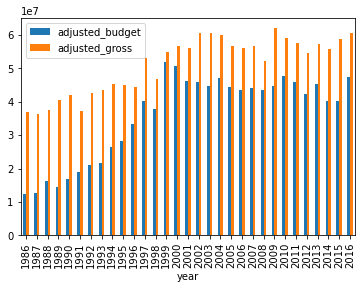

In [14]:
# Question: Should we consider 'year' as a feature?
year_group = merged_df_genres.groupby('year')[['adjusted_budget', 'adjusted_gross']].mean()
yearly_gross = pd.DataFrame(year_group)
yearly_gross.plot(kind='bar')

**Answer:** Yes, we consider 'year' as a feature.<br>
**Reason:** The average gross (box office) are fairly consistent through the 2000s but lower ('budget' *as an input feature* is even more significantly lower) in the 1980s-1990s likely becasue movie industry continues to grow. Thus, which year one is making movies in does have an effect on the potential box office the movie generates.

<AxesSubplot:xlabel='month'>

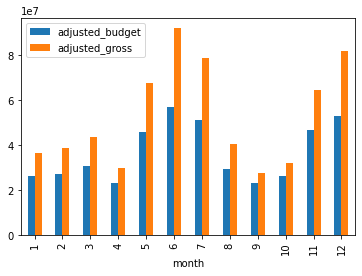

In [15]:
# Question: Should we consider 'month' as a feature?
month_group = merged_df_genres.groupby('month')[['adjusted_budget', 'adjusted_gross']].mean()
monthly_gross = pd.DataFrame(month_group)
monthly_gross.plot(kind='bar')

**Answer:** Yes, we consider 'month' as a feature. But we will only use the encoded month columns instead of the 1D 'month' column. Also, we further take it a step further and use the seasons columns in place of the months columns since it's more qualitatively meaningful.<br>
**Reason:** It's obvious that in the summer and during the end of a year (Christmas) are the times big hits are released most often thus they're making more average gross value (box office). There could also be further insight than the seasonality displayed here thus month will be a good input feature for our model.

<AxesSubplot:xlabel='rating'>

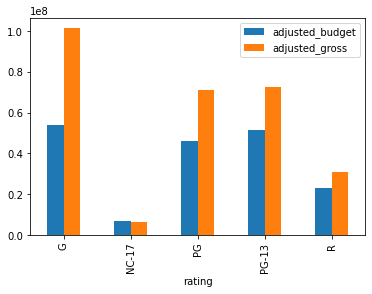

In [16]:
# Question: Should we consider 'rating' as a feature?
rating_group = merged_df_genres.groupby('rating')[['adjusted_budget', 'adjusted_gross']].mean()
rating_gross = pd.DataFrame(rating_group)
rating_group.plot(kind='bar')

**Answer:** Yes, we consider 'rating' as a feature.<br>
**Reason:** Movies rated 'NC-17' seem to be making the least box office. It makes sense because almost no big hits are made under that rating as the extra limit placed on the audience is also a consideration for production companies while considering profitability. Similarly, 'R' rated movies also make less money compared with other more "kids-friendly" ratings. 'rating' will likely have a significant impact on our model thus we will include.

<AxesSubplot:xlabel='genre_kaggle'>

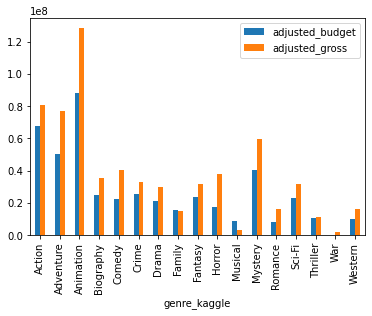

In [17]:
# Question: Should we consider the genres as features?
genres_group = merged_df_genres.groupby('genre_kaggle')[['adjusted_budget', 'adjusted_gross']].mean()
genres_gross = pd.DataFrame(genres_group)
genres_gross.plot(kind='bar')

**Answer:** Yes, we should probably consider the genres as features.<br>
**Reason:** This is a value_counts() bar chart plotted using the 'genre_kaggle' column which comes from the Kaggle dataset collected by the author. It is unclear how the one and only genre for each movie is selected (we suspect it's the first one in the alphebatical order), but it still gives us some insights as to if genre plays a role in box office. And it looks like it does have an impact.

<hr>

In [18]:
# Check how many movies do not have a budget assigned from the dataset that was scraped from IMDB
merged_df_genres['adjusted_budget'].value_counts()

0            1736
24041560       16
24964648       16
23738031       12
39755914       11
             ... 
4486687         1
224681830       1
18409329        1
5443444         1
76861434        1
Name: adjusted_budget, Length: 1971, dtype: int64

### Summarize feature selections

**Wanted Features - X:**

* **'runtime'** --> Use as is. Will be scaled.
* **'year' and All the seasons** --> We demonstrated trends over years and seasonality above. Already encoded.
* **'score_imdb', 'votes_imdb'** --> Score reflcts the critics and the public's perception/evaluations objectively; votes reflects movies' popularity. 'votes_imdb' will be scaled.
* **'adjusted_budget'** --> Use as is. A good amount of movies have a budget of "0" which likely reflects unreported data. Will be scaled.
* **All the genres** --> Some genres are more popular than the others. Already encoded.
* **'rating'** --> We demonstrated rating's impact above. Will need to be encoded.

**Output Value - y:**

* **'adjusted_gross'** --> **Our model will predict how much money in the initial box office (within US) a movie would make.**

<hr>

# Encoding Features

In [19]:
# Encode 'rating'
# ---------------
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(merged_df_genres['rating'])
rating_encoded = merged_df_genres.copy()
rating_encoded['rating'] = label_encoder.transform(rating_encoded['rating'])

# Visualize encoded y 
for label, original_class in zip(rating_encoded['rating'][0:20], merged_df_genres['rating'][0:20]):
    print('Original Class: ' + str(original_class))
    print('Encoded Label: ' + str(label))
    print('-' * 12)

Original Class: PG-13
Encoded Label: 3
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: PG-13
Encoded Label: 3
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: PG-13
Encoded Label: 3
------------
Original Class: R
Encoded Label: 4
------------
Original Class: R
Encoded Label: 4
------------
Original Class: PG
Encoded Label: 2
------------
Original Class: PG
Encoded Label: 2
------------
Original Class: R
Encoded Label: 4
------------
Original Class: PG-13
Encoded Label: 3
------------
Original Class: PG
Encoded Label: 2
------------
Original Class: PG-13
Encoded Label: 3
------------


In [20]:
# Check
print(label_encoder.classes_)
print(list(rating_encoded['rating']))

['G' 'NC-17' 'PG' 'PG-13' 'R']
[3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 2, 2, 4, 3, 2, 3, 4, 4, 4, 2, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 2, 3, 3, 4, 3, 3, 2, 4, 3, 2, 4, 3, 4, 3, 4, 4, 4, 3, 3, 3, 4, 2, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 2, 4, 2, 2, 4, 4, 3, 3, 3, 4, 4, 3, 3, 4, 4, 2, 4, 3, 3, 3, 2, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, 3, 4, 3, 3, 4, 2, 3, 3, 4, 4, 4, 4, 2, 3, 4, 2, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 2, 3, 3, 3, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 2, 4, 2, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 2, 4, 3, 3, 3, 2, 4, 3, 4, 3, 3, 3, 2, 3, 4, 4, 2, 2, 4, 3, 4, 3, 3, 4, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 2, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 4, 0, 4, 4, 3, 3, 4, 4, 3, 3, 2, 3, 4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 2, 2, 4, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2, 3, 3, 4, 3, 3, 4, 4, 4, 2, 3, 3, 4, 2, 4, 2, 4, 4, 3, 4, 2, 3,

In [21]:
# Number of rows check up
len(rating_encoded)

5949

In [22]:
rating_encoded.head(2)

,name,production,director,runtime,released,year,month,country_kaggle,country_omdb,star_kaggle,actors_omdb,writer_kaggle,writers_omdb,language_omdb,plot,awards,score_imdb,votes_imdb,score_metacritic,budget,genre_kaggle,gross,genres_omdb,rating,adjusted_budget,adjusted_gross,spring,summer,fall,winter,action,adventure,fantasy,sci-fi,crime,drama,history,comedy,biography,romance,horror,thriller,war,animation,family,sport,music,mystery,short,western,musical,documentary,film-noir,adult
0,Doctor Strange,Marvel Studios,Scott Derrickson,115,2016-11-04,2016,11,USA,USA,Benedict Cumberbatch,"Benedict Cumberbatch, Chiwetel Ejiofor, Rachel...",Jon Spaihts,"Jon Spaihts, Scott Derrickson, C. Robert Cargi...",English,"Marvel's ""Doctor Strange"" follows the story of...",Nominated for 1 Oscar. Another 19 wins & 67 no...,7.5,348307,72.0,165000000,Action,232641920,"Action, Adventure, Fantasy, Sci-Fi",3,177927373,250868883,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sleight,Diablo Entertainment (II),J.D. Dillard,89,2017-04-28,2016,4,USA,USA,Jacob Latimore,"Jacob Latimore, Seychelle Gabriel, Storm Reid,...",J.D. Dillard,"J.D. Dillard, Alex Theurer",English,A young street magician (Jacob Latimore) is le...,3 nominations.,5.9,4012,62.0,250000,Action,3986245,"Crime, Drama, Sci-Fi",4,269587,4298558,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Select features - pt 2

Now we select the features we will build into the model.

In [23]:
all_features = list(rating_encoded.columns)

unwanted = ['name', 'production', 'director', 'released',
            'country_kaggle', 'country_omdb', 'star_kaggle', 'actors_omdb',
            'writer_kaggle', 'writers_omdb', 'language_omdb', 'plot',
            'awards', 'score_metacritic', 'genre_kaggle', 'genres_omdb',
            'budget', 'gross', 'month'
           ]
wanted = []

for feature in all_features:
    if feature not in unwanted:
        wanted.append(feature)

new_df = rating_encoded[wanted]
new_df.columns

Index(['runtime', 'year', 'score_imdb', 'votes_imdb', 'rating',
       'adjusted_budget', 'adjusted_gross', 'spring', 'summer', 'fall',
       'winter', 'action', 'adventure', 'fantasy', 'sci-fi', 'crime', 'drama',
       'history', 'comedy', 'biography', 'romance', 'horror', 'thriller',
       'war', 'animation', 'family', 'sport', 'music', 'mystery', 'short',
       'western', 'musical', 'documentary', 'film-noir', 'adult'],
      dtype='object')

In [24]:
# Rearrage column orders
rearranged_df = new_df[['runtime', 'votes_imdb', 'adjusted_budget', # X to be scaled
                        'year',
                        'spring', 'summer', 'fall', 'winter', # All the seasons
                        'score_imdb', 'rating', # X not to be scaled
                        'crime', 'drama', 'romance', 'animation', 'comedy', # All the genres
                        'family', 'mystery', 'sci-fi', 'thriller', 'adventure',
                        'fantasy', 'action', 'biography', 'horror', 'history',
                        'war', 'music', 'sport', 'short', 'western', 'musical',
                        'documentary', 'film-noir', 'adult',
                        'adjusted_gross' # output y
                       ]]
rearranged_df.head(2)

,runtime,votes_imdb,adjusted_budget,year,spring,summer,fall,winter,score_imdb,rating,crime,drama,romance,animation,comedy,family,mystery,sci-fi,thriller,adventure,fantasy,action,biography,horror,history,war,music,sport,short,western,musical,documentary,film-noir,adult,adjusted_gross
0,115,348307,177927373,2016,0,0,0,1,7.5,3,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,250868883
1,89,4012,269587,2016,1,0,0,0,5.9,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4298558


In [25]:
print(len(rearranged_df.columns) == len(new_df.columns))
print(len(rearranged_df.columns))

True
35


In [26]:
# Set features as X and output as y
X = rearranged_df.drop("adjusted_gross", axis=1)
y = rearranged_df['adjusted_gross'].values.reshape(-1, 1)

print(X.shape, y.shape)

(5949, 34) (5949, 1)


# Create a Train Test Split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
X_train.head()

,runtime,votes_imdb,adjusted_budget,year,spring,summer,fall,winter,score_imdb,rating,crime,drama,romance,animation,comedy,family,mystery,sci-fi,thriller,adventure,fantasy,action,biography,horror,history,war,music,sport,short,western,musical,documentary,film-noir,adult
1340,107,223114,102541450,2009,1,0,0,0,6.6,3,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
831,95,218179,39453927,2012,0,0,1,0,7.1,4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5195,83,983,0,1989,0,0,0,1,4.4,2,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1456,100,3453,12063700,2009,0,0,1,0,5.9,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1769,122,54367,0,2007,1,0,0,0,7.7,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


# Scaling and Normalization

Scale the data using the StandardScaler.

In [29]:
# These features and y values are chosen to be scaled because the data is heavily skewed
from sklearn.preprocessing import MinMaxScaler

# Transform selected X ('runtime', 'votes_imdb', 'adjusted_budget')
X_scaler = MinMaxScaler().fit(X_train.iloc[:, :3])

X_train.iloc[:, :3] = X_scaler.transform(X_train.iloc[:, :3])
X_test.iloc[:, :3] = X_scaler.transform(X_test.iloc[:, :3])

/Users/ZTC/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/ZTC/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [30]:
X_train.head(3)

,runtime,votes_imdb,adjusted_budget,year,spring,summer,fall,winter,score_imdb,rating,crime,drama,romance,animation,comedy,family,mystery,sci-fi,thriller,adventure,fantasy,action,biography,horror,history,war,music,sport,short,western,musical,documentary,film-noir,adult
1340,0.247826,0.119798,0.318408,2009,1,0,0,0,6.6,3,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
831,0.195652,0.117147,0.122511,2012,0,0,1,0,7.1,4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5195,0.143478,0.000473,0.000000,1989,0,0,0,1,4.4,2,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
X_test.head(3)

,runtime,votes_imdb,adjusted_budget,year,spring,summer,fall,winter,score_imdb,rating,crime,drama,romance,animation,comedy,family,mystery,sci-fi,thriller,adventure,fantasy,action,biography,horror,history,war,music,sport,short,western,musical,documentary,film-noir,adult
4037,0.269565,0.001166,0.021093,1995,0,1,0,0,6.0,4,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4245,0.204348,0.004545,0.081341,1994,0,0,0,1,5.4,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1966,0.252174,0.081777,0.039864,2006,0,0,1,0,6.2,4,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [32]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [33]:
# Transform y
y_scaler = MinMaxScaler().fit(y_train)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [34]:
y_train_scaled

array([[0.28151981],
       [0.0147839 ],
       [0.01095517],
       ...,
       [0.00195886],
       [0.01278817],
       [0.05715031]])

<hr>

# Train the Model

**Multiple Linear Regression**

In [35]:
mlr_model = LinearRegression()

In [45]:
mlr_model.fit(X_train_scaled, y_train_scaled)

score_train = mlr_model.score(X_train_scaled, y_train_scaled)
score_test = mlr_model.score(X_test_scaled, y_test_scaled)

print(f'Model Scores')
print(f'Training Data Score: {round(score_train, 4)}')
print(f'Testing Data Score: {round(score_test, 4)}')

Model Scores
Training Data Score: 0.6158
Testing Data Score: 0.5895


**Observation on model performance:**
* This model's R2 score on the test data is 0.59.
* The training and testing score is very close.

### Visualize model performance with a residual plot

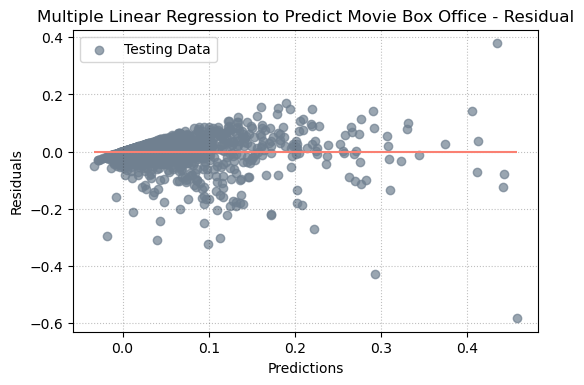

In [37]:
predictions = mlr_model.predict(X_test_scaled)

plt.figure(dpi=100)

plt.scatter(predictions, predictions - y_test_scaled, alpha=0.7,
            color='slategrey', label='Testing Data')

plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='salmon')

plt.grid(True, color='k', linestyle=':', alpha=0.25)
plt.title("Multiple Linear Regression to Predict Movie Box Office - Residual")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.legend()

plt.savefig('../../image_highlights/boxoffice_linear_regression/mlr_residual_plot.png')
plt.show()

### Visualize the estimated coefficients for the linear regression

In [38]:
coefficients = list(mlr_model.coef_.reshape(-1, 1))
coefficients_list = []

for coef in coefficients:
    coefficients_list.append(round(coef[0], 4))

data = {
    'features': list(X_test_scaled.columns),
    'coefficients': coefficients_list
}

# Create df
coef_df = pd.DataFrame(data, columns=['features', 'coefficients'])

In [39]:
all_genres = genres_list[3:]

general = ['votes_imdb', 'score_imdb',
          'runtime', 'adjusted_budget', 'rating']
year = ['year']
seasons = ['spring', 'summer', 'fall', 'winter']

coef_df['feature_type'] = ''

for index, row in coef_df.iterrows():
    if coef_df.loc[index, 'features'] in all_genres:
        coef_df.loc[index, 'feature_type'] = 'Genre'
    elif coef_df.loc[index, 'features'] in general:
        coef_df.loc[index, 'feature_type'] = 'General'
    elif coef_df.loc[index, 'features'] in year:
        coef_df.loc[index, 'feature_type'] = 'Year'
    elif coef_df.loc[index, 'features'] in seasons:
        coef_df.loc[index, 'feature_type'] = 'Season'

coef_df = coef_df.sort_values(by='feature_type', ascending=False)
coef_df = coef_df.sort_values(by='coefficients', ascending=False)

coef_df

,features,coefficients,feature_type
1,votes_imdb,0.4599,General
2,adjusted_budget,0.2235,General
32,film-noir,0.0231,Genre
0,runtime,0.0219,General
15,family,0.0117,Genre
13,animation,0.0098,Genre
5,summer,0.0082,Season
14,comedy,0.0068,Genre
26,music,0.0056,Genre
19,adventure,0.0046,Genre


In [40]:
# Divide coef df...
coef_general = coef_df.loc[coef_df['feature_type'] == 'General']
coef_genre = coef_df.loc[coef_df['feature_type'] == 'Genre']

# Time related coefficients
coef_year = coef_df.loc[coef_df['feature_type'] == 'Year']
coef_season = coef_df.loc[coef_df['feature_type'] == 'Season']

coef_time = pd.concat([coef_year, coef_season], ignore_index=True)

In [41]:
# "Feature importances" of general features
coef_general

,features,coefficients,feature_type
1,votes_imdb,0.4599,General
2,adjusted_budget,0.2235,General
0,runtime,0.0219,General
8,score_imdb,0.0031,General
9,rating,-0.0068,General


**Observations on general feature importances:**
* *IMDB votes* and *film budget* have significant positive impact on movie box office.
* *IMDB score* doesn't have a big impact on box office relatively speaking.
* "rating" doesn't have a negative impact on box office.

In [42]:
# "Feature importances" of time related features
coef_time

,features,coefficients,feature_type
0,year,-0.0008,Year
1,summer,0.0082,Season
2,winter,0.0008,Season
3,spring,-0.0016,Season
4,fall,-0.0074,Season


**Observations on time related feature importances:**
* *year* virtually has minimal to none impact on box office, indicating how much revenue a movie can potentially generate in terms of box office is likely not going to be determined by which year it is released.
* The season with the most positive impact is summer, the season with the most negative impact is fall.

In [43]:
# "Feature importances" of genres
coef_genre

,features,coefficients,feature_type
32,film-noir,0.0231,Genre
15,family,0.0117,Genre
13,animation,0.0098,Genre
14,comedy,0.0068,Genre
26,music,0.0056,Genre
19,adventure,0.0046,Genre
27,sport,0.0041,Genre
12,romance,0.0041,Genre
23,horror,0.0029,Genre
16,mystery,0.0024,Genre


**Observations on genres feature importances:**
* In general genres do not play a significant part on how much box office a movie can generate. 
* Among all, genre *film-noir* is relatively the most impactful in terms of absolute value of coefficient, and genre *documentary* doesn't seem to do well in movie theatres.

# Save the Model

In [44]:
import joblib

filename = os.path.join('..', '..', 'saved_models','boxoffice_linear_regression.sav')
joblib.dump(mlr_model, filename)

['../../saved_models/boxoffice_linear_regression.sav']